In [ ]:
import sys
!{sys.executable} -m pip install git+https://github.com/decibelcooper/nngpt.git

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import logging
logging.basicConfig(
format="%(levelname)s %(funcName)s():%(lineno)i: %(message)s",
)

# Readout segmentation

In [3]:
import numpy as np
import random as rand
from scipy import spatial

# read in pad file
with open('3d.kicad_pcb') as f:
    text = f.read()

class PcbObject:
    pass

def skip_content(s, begin):
    while True:
        l = s.find('(', begin)
        r = s.find(')', begin)
        if r < l or l == -1:
            return r+1
        begin = skip_content(s, l+1)

def build_tree(s, begin, depth):
    pcbobj = []
    while True:
        l = s.find('(', begin)
        r = s.find(')', begin)
        if r < l or l == -1:
            if len(pcbobj) == 0:
                return s[begin:r], r+1
            else:
                return pcbobj, r+1
        begin = l+1
        space = s.find(' ', begin)
        obj = PcbObject()
        obj.name = s[begin:space].strip()
        if depth != 1 or obj.name == 'via' or obj.name == 'net':
            obj.content, begin = build_tree(s, space+1, depth+1)
            pcbobj.append(obj)
        else:
            begin = skip_content(s, space+1)

pcb_tree, _ = build_tree(text, 0, 0)
if len(pcb_tree) != 1:
    raise Exception('bad pcb tree structure with length', len(pcb_tree))
if pcb_tree[0].name != 'kicad_pcb':
    raise Exception('not a kicad pcb file')
kicad_pcb = pcb_tree[0]

# build arrays mapping pads to channel numbers
min_c = [sys.maxsize, sys.maxsize, sys.maxsize]
pad_a = []
pad_ac = []
pad_x = []
pad_y = []
net_map = {}
axis_map = {'a': 1, 'b': 2, 'c': 0}
axis_flip = {'a': 1, 'b': -1, 'c': 1}
gnd_net = 'GND'

for obj in kicad_pcb.content:
    if obj.name == 'net':
        split = obj.content.split()
        net_map[int(split[0])] = split[1]
    elif obj.name == 'via':
        net = ''
        at = (0,0)
        for obj1 in obj.content:
            if obj1.name == 'at':
                split = obj1.content.split()
                at = (float(split[0]), float(split[1]))
            elif obj1.name == 'net':
                net = net_map[int(obj1.content.split()[0])]
        if net[0] in axis_map:
            try:
                axis = axis_map[net[0]]
                channel = axis_flip[net[0]] * int(net[1:])
                if channel < min_c[axis]:
                    min_c[axis] = channel
                pad_a.append(axis)
                pad_ac.append(channel)
                pad_x.append(at[0])
                pad_y.append(at[1])
            except:
                continue
        elif net == gnd_net:
            pad_a.append(-1)
            pad_ac.append(-1)
            pad_x.append(at[0])
            pad_y.append(at[1])

pad_ac = np.array(pad_ac)
n_axis_chans = len(np.unique(pad_ac[np.flatnonzero(np.array(pad_a) == 0)]))

pad_c = [-1]*len(pad_ac)
for i in range(0, len(pad_ac)):
    a = pad_a[i]
    ac = pad_ac[i] - min_c[a]
    if a >= 0 and ac >= 0:
        pad_c[i] = n_axis_chans * a + ac

pad_x = np.array(pad_x)
pad_y = np.array(pad_y)
pad_c = np.array(pad_c)

chans = np.unique(pad_c)
n_chans = len(chans)
if -1 in chans:
    n_chans -= 1

# define nearest channel sample binning using native KDTree search
pad_tree = spatial.cKDTree(np.transpose([pad_x, pad_y]))
def chan_counts(xy, split=True, randomize=True):
    if randomize:
        np.random.shuffle(xy)

    # split the samples evenly between the anode and cathode
    if split:
        xy = xy[:len(xy)//2]
        
    _, pads = pad_tree.query(xy)
    pads, counts = np.unique(pads, return_counts=True)
    try:
        pads, counts = zip(*filter(lambda x: x[0] < len(pad_c), zip(pads, counts)))
        return zip(pad_c[list(pads)], counts)
    except ValueError:
        return []

# Tomography

In [4]:
import logging
import nngpt

logging.getLogger().setLevel(logging.INFO)

# initialize planar nonnegative gaussian process tomography
p = nngpt.Planar(
    n_chans,
    chan_counts,
    m=100, n=100,
    sample_density=10000,
)

INFO _init_design():133: g integration time: 75.044
INFO _init_design():178: covariance matrix calculation time: 23.907


In [5]:
import logging
import nngpt
import matplotlib.pyplot as plt

def plot_tomo_for_samples(xy, name, n_std=4, seg_name='3-D'):
    logging.getLogger().setLevel(logging.INFO)

    xy_diff = nngpt.add_diffusion(xy, p.max_diff_sigma)
    q = p.bin_channels(xy_diff)
    img = p.tomo(q)
    mean, cov = p.get_mean_and_cov(img)
    true_img = p.bin_pixels(xy)
    true_mean, true_cov = p.get_mean_and_cov(true_img)

    print('Simulated channel input')
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot()
    ax.plot(q)
    ax.set_xlabel('readout channel')
    ax.set_yscale('log')
    fig.savefig(f'{seg_name}_{name}_channel-response.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

    print(f'True image with calculated {n_std}-sigma confidence ellipse')
    fig = nngpt.draw_tomo(
        true_img, p.width, p.height, colorbar=True,
        mean=[None], cov=[None],
        true_mean=[[true_mean]], true_cov=[[true_cov]],
        n_std=n_std,
    )
    for ax in fig.axes:
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        break
    fig.savefig(f'{name}_truth-img.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    print(f'Reconstructed image with overlayed confidence ellipses')
    fig = nngpt.draw_tomo(
        img, p.width, p.height, colorbar=True,
        true_mean=[[true_mean]], true_cov=[[true_cov]],
        mean=[[mean]], cov=[[cov]],
        n_std=n_std,
    )
    for ax in fig.axes:
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        break
    fig.savefig(f'{seg_name}_{name}_reco-img.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    print('Differences in the images and overlayed confidence ellipses')
    fig = nngpt.draw_tomo(
        img-true_img, p.width, p.height, colorbar=True,
    )
    for ax in fig.axes:
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        break
    fig.savefig(f'{seg_name}_{name}_diff-img.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

## Covariant Gaussian

INFO sample_normal():16: sampling time: 0.133
INFO add_diffusion():67: sampling time: 0.162
INFO bin_channels():59: binning time: 1.521
INFO tomo():41: tomography time: 3.405
INFO tomo():42: tomography iterations: 12
INFO tomo():43: unconstrained pixel count: 208
INFO bin_pixels():72: binning time: 0.636


Simulated channel input


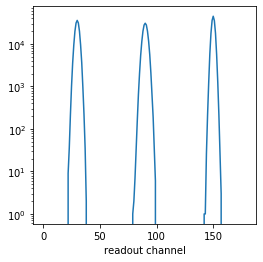

True image with calculated 4-sigma confidence ellipse


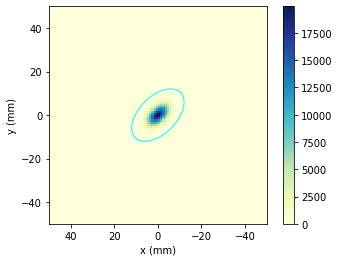

Reconstructed image with overlayed confidence ellipses


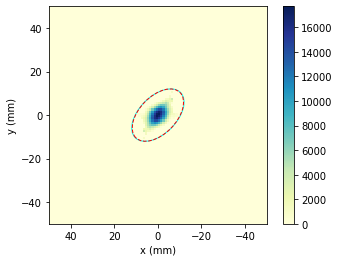

Differences in the images and overlayed confidence ellipses


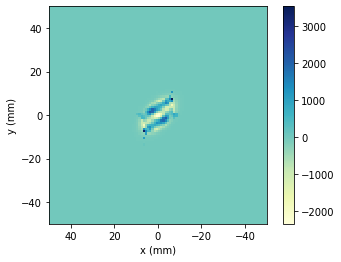

In [6]:
import nngpt
import numpy as np

means = np.array([[0,0]])
covs = 9*np.array([[[1,-0.5],[-0.5,1]]])
n_samples = [1e6]

xy = nngpt.sample_normal(means, covs, n_samples)
plot_tomo_for_samples(xy, 'cov-gauss')

## Two Gaussians

INFO sample_normal():16: sampling time: 0.177
INFO add_diffusion():67: sampling time: 0.231
INFO bin_channels():59: binning time: 3.125
INFO tomo():41: tomography time: 0.086
INFO tomo():42: tomography iterations: 10
INFO tomo():43: unconstrained pixel count: 245
INFO bin_pixels():72: binning time: 1.198


Simulated channel input


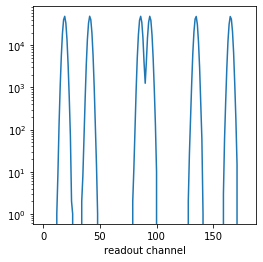

True image with calculated 4-sigma confidence ellipse


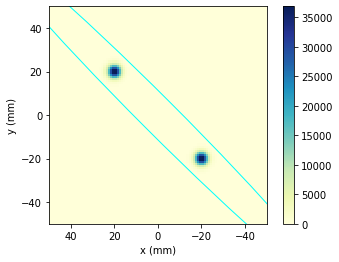

Reconstructed image with overlayed confidence ellipses


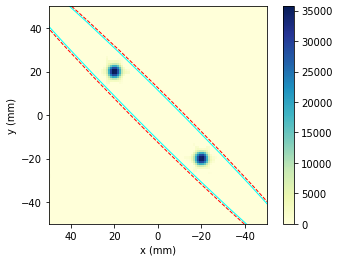

Differences in the images and overlayed confidence ellipses


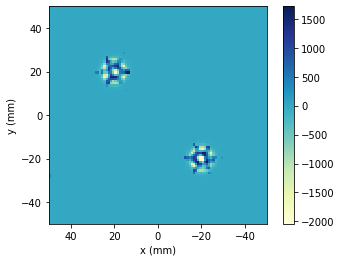

In [7]:
import nngpt
import numpy as np

means = 20*np.array([[1,1],[-1,-1]])
covs = 4*np.array([[[1,0],[0,1]],[[1,0],[0,1]]])
n_samples = [1e6,1e6]

xy = nngpt.sample_normal(means, covs, n_samples)
plot_tomo_for_samples(xy, 'double-gauss')

## Circle convolved with Gaussian

INFO sample_circle():33: sampling time: 1.626
INFO add_diffusion():67: sampling time: 0.961
INFO bin_channels():59: binning time: 15.665
INFO tomo():41: tomography time: 0.088
INFO tomo():42: tomography iterations: 11
INFO tomo():43: unconstrained pixel count: 669
INFO bin_pixels():72: binning time: 6.647


Simulated channel input


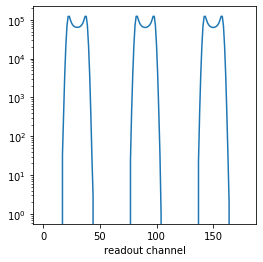

True image with calculated 4-sigma confidence ellipse


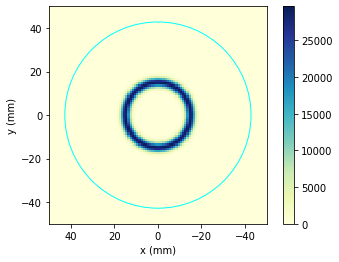

Reconstructed image with overlayed confidence ellipses


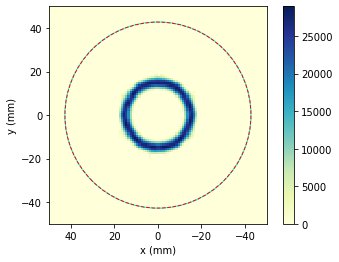

Differences in the images and overlayed confidence ellipses


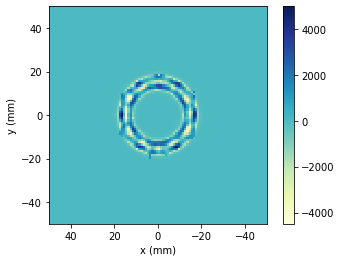

In [8]:
import nngpt

xy = nngpt.sample_circle()
plot_tomo_for_samples(xy, 'circle')

## Square convolved with Gaussian

INFO sample_square():54: sampling time: 1.140
INFO add_diffusion():67: sampling time: 1.116
INFO bin_channels():59: binning time: 15.623
INFO tomo():41: tomography time: 0.094
INFO tomo():42: tomography iterations: 11
INFO tomo():43: unconstrained pixel count: 771
INFO bin_pixels():72: binning time: 6.455


Simulated channel input


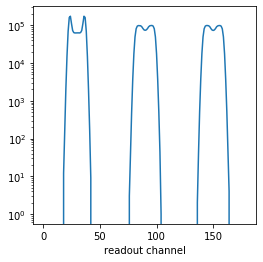

True image with calculated 4-sigma confidence ellipse


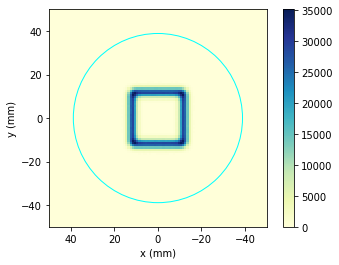

Reconstructed image with overlayed confidence ellipses


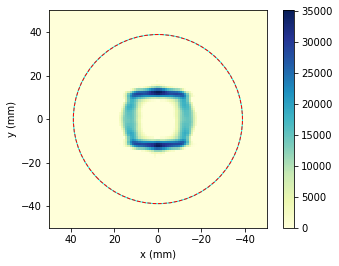

Differences in the images and overlayed confidence ellipses


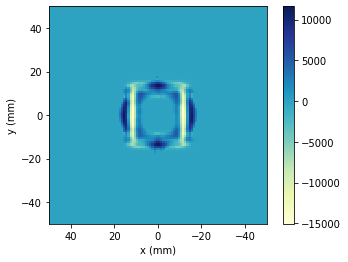

In [9]:
import nngpt

xy = nngpt.sample_square()
plot_tomo_for_samples(xy, 'square')

## Execution time benchmark using covariant Gaussian

In [10]:
import logging
import nngpt

logging.getLogger().setLevel(logging.ERROR)

means = np.array([[0,0]])
covs = 9*np.array([[[1,-0.5],[-0.5,1]]])
n_samples = [1e6]

xy = nngpt.sample_normal(means, covs, n_samples)
xy_diff = nngpt.add_diffusion(xy, p.max_diff_sigma)
q = p.bin_channels(xy_diff)

%timeit p.tomo(q, ret_pixels=False)

66.7 ms ± 588 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
